In [9]:
import numpy as np
timeSeries = np.arange(31)
timeSeries

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [10]:
def split_sequence(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y = list(), list()
    for i in range(len(sequence)):
        i = n_steps_jump*i;
        # Descobrir o indice da ultima amostra
        end_ix = i + n_steps_input
        # Se tivermos chegado ao fim da serie paramos
        if end_ix+n_steps_forecast > len(sequence):
            break
        # Extrai training/testing data
        seq_x = sequence[i:end_ix] 
        X.append(seq_x)
        seq_y = sequence[end_ix:end_ix+n_steps_forecast]
        y.append(seq_y)
    return np.array(X), np.array(y)

In [431]:
def split_train_cv_forwardChaining(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    j=2; # Tracks index of CV set at each train/val split
    
    # Iterate through all train/val splits
    while 1:
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        
        # Iterate until index of individual training set is smaller than index of cv set
        while (i < j):
            ## TRAINING DATA
            start_ix = n_steps_jump*i;
            end_ix = start_ix + n_steps_input;
            
            seq_x = sequence[start_ix:end_ix] 
            X_it.append(seq_x)
            seq_y = sequence[end_ix:end_ix+n_steps_forecast]
            y_it.append(seq_y)
            
            i+=1;
          
        # Once val data crosses time series length return   
        if (((end_ix+n_steps_input)+n_steps_forecast) > len(sequence)):
            break
        
        ## CROSS-VALIDATION DATA
        startCv_ix = end_ix;
        endCv_ix = end_ix + n_steps_input;
        
        seq_xcv = sequence[startCv_ix:endCv_ix] 
        Xcv_it.append(seq_xcv)
        seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
        ycv_it.append(seq_ycv) 
            
        ## Add another train/val split 
        X[j-2] = np.array(X_it)
        y[j-2] = np.array(y_it)
        Xcv[j-2] = np.array(Xcv_it)
        ycv[j-2] = np.array(ycv_it)
        
        j+=1;
            
    return X, y, Xcv, ycv

X, y, Xcv, ycv = split_train_cv_forwardChaining(timeSeries, n_steps_input=4, n_steps_forecast=3, n_steps_jump=2)
for j in np.arange(1):
    print("--------- ROUND %d ---------" % j)
    print("----- X[%d]"% j)
    print(X[j])
    print("----- y[%d]"% j)
    print(y[j])
    print("----- Xcv[%d]"% j)
    print(Xcv[j])
    print("----- ycv[%d]"% j)
    print(ycv[j])

--------- ROUND 0 ---------
----- X[0]
[[0 1 2 3]
 [2 3 4 5]]
----- y[0]
[[4 5 6]
 [6 7 8]]
----- Xcv[0]
[[6 7 8 9]]
----- ycv[0]
[[10 11 12]]


In [433]:
def split_train_cv_kFold(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    j=2; # Tracks index of CV set at each train/val split
    theEnd = 0; # Flag to terminate function
    
    # Iterate until val set falls outside time series length
    while 1:
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        n=0; # Number of n_steps_jump
        
        # Iterate through all train/val splits
        while 1:
            if (i != j): 
                ## TRAINING DATA
                start_ix = endCv_ix + n_steps_jump*n;
                end_ix = start_ix + n_steps_input;
                n +=1;

                # Leave train/val split loop once training data crosses time series length
                if end_ix+n_steps_forecast > len(sequence):
                    break;

                seq_x = sequence[start_ix:end_ix] 
                X_it.append(seq_x)
                seq_y = sequence[end_ix:end_ix+n_steps_forecast]
                y_it.append(seq_y)
            else:
                ## CROSS-VALIDATION DATA
                startCv_ix = end_ix;
                endCv_ix = end_ix + n_steps_input;
                n = 0;
                
                # Once val data crosses time series length exit tran/val split loop and return
                if endCv_ix+n_steps_forecast > len(sequence):
                    theEnd = 1;
                    break;

                seq_xcv = sequence[startCv_ix:endCv_ix] 
                Xcv_it.append(seq_xcv)
                seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
                ycv_it.append(seq_ycv)
            i+=1;
        
        # Only add a train/val split if the time series length has not been crossed
        if (theEnd == 1):
            break
        
        ## Add another train/val split 
        X[j-2] = np.array(X_it)
        y[j-2] = np.array(y_it)
        Xcv[j-2] = np.array(Xcv_it)
        ycv[j-2] = np.array(ycv_it)
        
        j+=1;
            
    return X, y, Xcv, ycv

X, y, Xcv, ycv = split_train_cv_kFold(timeSeries, n_steps_input=4, n_steps_forecast=3, n_steps_jump=2)
for j in np.arange(1):
    print("--------- ROUND %d ---------" % j)
    print("----- X[%d]"% j)
    print(X[j])
    print("----- y[%d]"% j)
    print(y[j])
    print("----- Xcv[%d]"% j)
    print(Xcv[j])
    print("----- ycv[%d]"% j)
    print(ycv[j])

--------- ROUND 0 ---------
----- X[0]
[[ 0  1  2  3]
 [ 2  3  4  5]
 [10 11 12 13]
 [12 13 14 15]
 [14 15 16 17]
 [16 17 18 19]
 [18 19 20 21]
 [20 21 22 23]
 [22 23 24 25]]
----- y[0]
[[ 4  5  6]
 [ 6  7  8]
 [14 15 16]
 [16 17 18]
 [18 19 20]
 [20 21 22]
 [22 23 24]
 [24 25 26]
 [26 27 28]]
----- Xcv[0]
[[6 7 8 9]]
----- ycv[0]
[[10 11 12]]


In [435]:
def split_train_cv_multipleKFold(sequence, n_steps_input, n_steps_forecast, n_steps_jump):
    X, y, Xcv, ycv = dict(), dict(), dict(), dict()
    
    # Iterate through 5 train/val splits
    for j in np.arange(5):
        start_ix=0; end_ix=0; startCv_ix=0; endCv_ix=0;
        X_it, y_it, Xcv_it, ycv_it = list(), list(), list(), list()
        i=0; # Index of individual training set at each train/val split
        n=0; # Number of n_steps_jump
        
        while 1: 
            if ((i+1+j)%(5) != 0):
                # TRAINING DATA
                start_ix = endCv_ix + n_steps_jump*n;
                end_ix = start_ix + n_steps_input;
                n+=1;

                # Leave train/val split loop once training data crosses time series length
                if end_ix+n_steps_forecast > len(sequence)-1:
                    break 

                seq_x = sequence[start_ix:end_ix] 
                X_it.append(seq_x)
                seq_y = sequence[end_ix:end_ix+n_steps_forecast]
                y_it.append(seq_y)
            else:
                # CROSS-VALIDATION DATA
                startCv_ix = end_ix;
                endCv_ix = end_ix + n_steps_input;
                n=0;

                # Once val data crosses time series length return   
                if ((endCv_ix+n_steps_forecast) > len(sequence)):
                    break

                seq_xcv = sequence[startCv_ix:endCv_ix] 
                Xcv_it.append(seq_xcv)
                seq_ycv = sequence[endCv_ix:endCv_ix+n_steps_forecast]
                ycv_it.append(seq_ycv)  
                
            i+=1;
            
        ## Add another train/val split     
        X[j] = np.array(X_it)
        y[j] = np.array(y_it)
        Xcv[j] = np.array(Xcv_it)
        ycv[j] = np.array(ycv_it)
            
    return X, y, Xcv, ycv

X, y, Xcv, ycv = split_train_cv_multipleKFold(timeSeries, n_steps_input=4, n_steps_forecast=3, n_steps_jump=2)
for j in np.arange(5):
    print("--------- ROUND %d ---------" % j)
    print("----- X[%d]"% j)
    print(X[j])
    print("----- y[%d]"% j)
    print(y[j])
    print("----- Xcv[%d]"% j)
    print(Xcv[j])
    print("----- ycv[%d]"% j)
    print(ycv[j])

--------- ROUND 0 ---------
----- X[0]
[[ 0  1  2  3]
 [ 2  3  4  5]
 [ 4  5  6  7]
 [ 6  7  8  9]
 [14 15 16 17]
 [16 17 18 19]
 [18 19 20 21]
 [20 21 22 23]]
----- y[0]
[[ 4  5  6]
 [ 6  7  8]
 [ 8  9 10]
 [10 11 12]
 [18 19 20]
 [20 21 22]
 [22 23 24]
 [24 25 26]]
----- Xcv[0]
[[10 11 12 13]]
----- ycv[0]
[[14 15 16]]
--------- ROUND 1 ---------
----- X[1]
[[ 0  1  2  3]
 [ 2  3  4  5]
 [ 4  5  6  7]
 [12 13 14 15]
 [14 15 16 17]
 [16 17 18 19]
 [18 19 20 21]]
----- y[1]
[[ 4  5  6]
 [ 6  7  8]
 [ 8  9 10]
 [16 17 18]
 [18 19 20]
 [20 21 22]
 [22 23 24]]
----- Xcv[1]
[[ 8  9 10 11]
 [22 23 24 25]]
----- ycv[1]
[[12 13 14]
 [26 27 28]]
--------- ROUND 2 ---------
----- X[2]
[[ 0  1  2  3]
 [ 2  3  4  5]
 [10 11 12 13]
 [12 13 14 15]
 [14 15 16 17]
 [16 17 18 19]]
----- y[2]
[[ 4  5  6]
 [ 6  7  8]
 [14 15 16]
 [16 17 18]
 [18 19 20]
 [20 21 22]]
----- Xcv[2]
[[ 6  7  8  9]
 [20 21 22 23]]
----- ycv[2]
[[10 11 12]
 [24 25 26]]
--------- ROUND 3 ---------
----- X[3]
[[ 0  1  2  3]
 [ 8

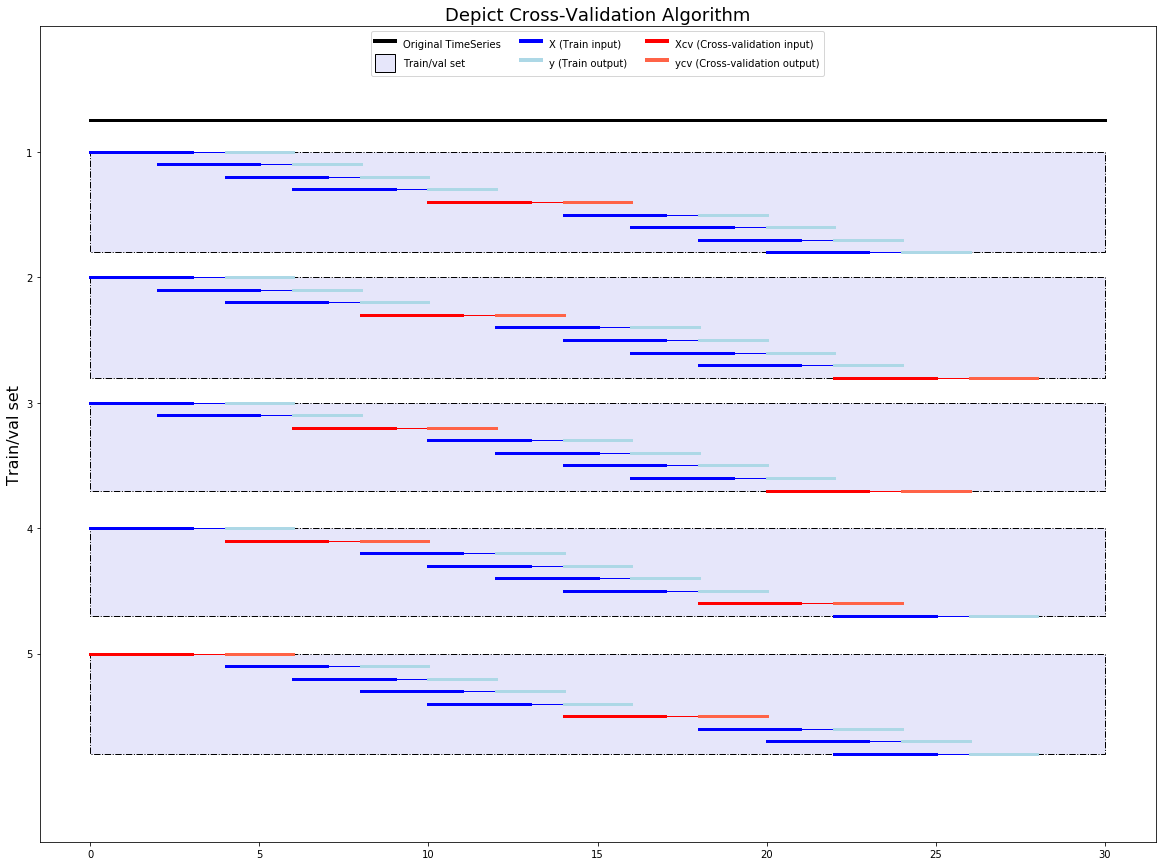

In [444]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
# Plot original time series in usage
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(timeSeries, len(timeSeries) * [len(X)-0.75], lw=3, c='k')
k = 1./max([len(x)+2 for x in X.values()])
numSets = len(X)
# Loop through train/val sets
for i in np.arange(numSets):
    sorted_arr = np.sort(np.array([x[0] for x in np.concatenate((X[i], Xcv[i]), axis=0)]))
    # Loop through training sets
    for j in np.arange(len(X[i])):
        level = sum(sorted_arr<X[i][j][0])
        plt.plot(X[i][j], len(X[i][j]) * [numSets-i-1-k*level], lw=3, c='blue')
        plt.plot([X[i][j][-1], y[i][j][0]], 2*[numSets-i-1-k*level], lw=1, c='blue')
        plt.plot(y[i][j], len(y[i][j]) * [numSets-i-1-k*level], lw=3, c='lightblue')
    # Loop through cross-validation sets
    for j in np.arange(len(Xcv[i])):
        level = sum(sorted_arr<Xcv[i][j][0])
        plt.plot(Xcv[i][j], len(Xcv[i][j]) * [numSets-i-1-k*level], lw=3, c='red')
        plt.plot([Xcv[i][j][-1], ycv[i][j][0]], 2*[numSets-i-1-k*level], lw=1, c='red')
        plt.plot(ycv[i][j], len(ycv[i][j]) * [numSets-i-1-k*level], lw=3, c='tomato')
    rect = patches.Rectangle((0, len(X)-i-1), len(timeSeries)-1, k*(-len(sorted_arr)+1), 
                             ls='-.', linewidth=1, edgecolor='k',facecolor='lavender')
    ax.add_patch(rect)
ax.grid(which='minor')
ax.set_yticks(np.arange(len(X), 0, -1)-1)
ax.set_yticklabels(np.arange(1, len(X)+1, 1))
ax.set_ylabel("Train/val set", size=16)
custom_lines = [Line2D([0], [0], color='k', lw=4),    patches.Patch(facecolor='lavender', edgecolor='k'),
                Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='lightblue', lw=4),
                Line2D([0], [0], color='red', lw=4),  Line2D([0], [0], color='tomato', lw=4)]
ax.legend(custom_lines, ['Original TimeSeries', 'Train/val set', 
                         'X (Train input)', 'y (Train output)', 
                         'Xcv (Cross-validation input)', 'ycv (Cross-validation output)'], 
          loc='upper center', ncol=3, handleheight=2.4, labelspacing=0.05)
ax.set_ylim([-1.5, len(X)])
ax.set_title('Depict Cross-Validation Algorithm', size=18);

In [3]:
from TimeSeriesCrossValidation.splitTrainValTest import didier_birthday, split_train_cv_forwardChaining
didier_birthday()

4 June 1995


In [4]:
X, y, Xcv, ycv = split_train_cv_forwardChaining(timeSeries, n_steps_input=4, n_steps_forecast=3, n_steps_jump=2)
for j in np.arange(1):
    print("--------- ROUND %d ---------" % j)
    print("----- X[%d]"% j)
    print(X[j])
    print("----- y[%d]"% j)
    print(y[j])
    print("----- Xcv[%d]"% j)
    print(Xcv[j])
    print("----- ycv[%d]"% j)
    print(ycv[j])

--------- ROUND 0 ---------
----- X[0]
[[0 1 2 3]
 [2 3 4 5]]
----- y[0]
[[4 5 6]
 [6 7 8]]
----- Xcv[0]
[[6 7 8 9]]
----- ycv[0]
[[10 11 12]]


In [8]:
?np.arange

In [7]:
?didier_birthday